In [228]:
import cv2
import wfdb as wf
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from lxml import etree
from matplotlib import pyplot as plt

%matplotlib inline

In [229]:
# Prepare data access
paths = glob('data/mitdb/*.dat')
paths = [path[:-4] for path in paths]
paths.sort()

# We want only the [beat annotations](http://www.physionet.org/physiobank/annotations.shtml), each as 240 points

In [230]:
beat_annotations = ['N', 'L', 'R', 'B',
                    'A', 'a', 'J', 'S', 'V',
                    'r', 'F', 'e', 'j', 'n',
                    'E', '/', 'f', 'Q', '?'] 
# 0.5 of how much signal we want per beat
half_qrs = 120


# Convert all of the data into classified fragments

In [232]:
# Prepare the final container
base = pd.DataFrame()

for path in tqdm(paths):
    # print 'Working with file:', path
    ann = wf.rdann(path, 'atr')
    record = wf.rdsamp(path)
    
    # We want just the signals
    data = record.p_signals
    
    # Prepare containers
    signals, classes = [], []
    
    # Beat extraction
    for it, beat in enumerate(ann.anntype):
        if beat in beat_annotations:
            # Defend from the dumb annotation hacking my folder structure
            if beat == '/': beat = 'C'
                
            sta = ann.annsamp[it] - half_qrs
            end = ann.annsamp[it] + half_qrs
            qrs = data[sta : end, :]
            
            # This may happen at the edges
            if len(qrs) != 2 * half_qrs: continue
            
            # Keep the channel type in the class name
            for ch in range(2):
                beat_class = '{}_{}'.format(record.signame[ch], beat)
                signals.append(qrs[:, ch])
                classes.append(beat_class)
                
    new_frame = pd.DataFrame({'qrs_data' : signals,
                              'qrs_type' : classes})
    # Cumulate
    base = base.append(new_frame)

100%|██████████| 48/48 [00:16<00:00,  2.54it/s]


# Let's see what kinds of qrs types are available
We only want examples with more than 200 occurances

In [233]:
classes = base['qrs_type'].value_counts()
ids = classes.iloc[:] > 700
classes = classes.loc[ids]

# Show just the top ten
print classes, classes.shape

MLII_N    74765
V1_N      65579
V1_L       8071
MLII_L     8071
MLII_R     7257
MLII_V     7123
V1_V       7029
V5_N       5833
V1_R       5726
V2_N       3877
V1_C       3619
MLII_C     3619
V5_C       3407
V2_C       3407
MLII_A     2546
V1_A       2498
V4_R       1531
MLII_F      802
V1_F        793
V5_f        722
V2_f        722
Name: qrs_type, dtype: int64 (21,)


In [234]:
# Extract just one exemplary qrs
classes = classes.index
qrs_type = classes[3]
ids = base['qrs_type'] == qrs_type

# Get all of that type
partial = base.loc[ids]

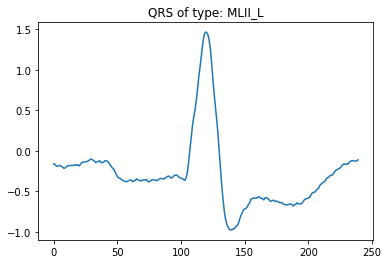

In [235]:
qrs = partial.iloc[123]['qrs_data']
plt.plot(qrs)
plt.title('QRS of type: {}'.format(qrs_type))

## Pure genius transformation of 1D signals into RGB images

In [236]:
# Stretch helper
def stretch(qrs, final_length):
    xa = np.linspace(0, 1, len(qrs))
    xb = np.linspace(0, 1, final_length)
    
    longer = np.interp(xb, xa, qrs)
    
    return longer

In [237]:
# Box generator
def get_box(qrs, left_offset):
    # Up and down are trivial
    top = qrs.min()
    bot = qrs.max()
    
    # Find the middle point of the signal
    middle = len(qrs) / 2 + left_offset
    
    # Make boxes with different widths, why not
    box_half = 60 + np.random.randint(80)
    left = middle - box_half
    right = middle + box_half
    
    return left, right, top, bot

In [238]:
# Constant factors
height = 400
scale_factor = 4

# Reshape to fit the screen
def reshape(qrs, top_offset):
    # Rescale the qrs (and flip)
    qrs = -qrs
    qrs -= qrs.min()
    qrs /= scale_factor

    # Prepare to be and y-position
    qrs = qrs * height
    qrs = qrs.astype('uint16')
    qrs += top_offset
    
    return qrs

In [246]:
# Keep the tensorflow object_detection API standards for annotations
def make_annotation(img, qrs_type, box, it):
    # Prepare the xml tree ...
    root = etree.Element('annotation')
    
    # Source branch
    source = etree.SubElement(root, 'source')
    e_width = etree.SubElement(source, 'width')
    e_width.text = str(img.shape[0])
    e_height = etree.SubElement(source, 'height')
    e_height.text = str(img.shape[1])
    e_depth = etree.SubElement(source, 'depth')
    e_depth.text = str(img.shape[2])
    
    # Object branch
    e_object = etree.SubElement(root, 'object')
    e_class = etree.SubElement(e_object, 'class')
    e_class.text = qrs_type
    
    # Bounding box
    bndbox = etree.SubElement(e_object, 'bndbox')
    xmin = etree.SubElement(bndbox, 'xmin')
    xmin.text = str(box[0])
    xmax = etree.SubElement(bndbox, 'xmax')
    xmax.text = str(box[1])
    
    ymin = etree.SubElement(bndbox, 'ymin')
    ymin.text = str(box[2])
    ymax = etree.SubElement(bndbox, 'ymax')
    ymax.text = str(box[3])
    savepath = 'data/annotations/{}_{}.xml'.format(qrs_type, it)
    
    # Use this tree to save it 
    tree = etree.ElementTree(root)
    tree.write(savepath)   
    

In [248]:
# Prepare the dataset
for qrs_type in tqdm(classes):
    # Get all of that type
    ids = base['qrs_type'] == qrs_type
    partial = base.loc[ids]
    
    for it in range(10):
        qrs = partial.iloc[it]['qrs_data']

        # Randomize on-screen localization
        top_offset = 130 + np.random.randint(-40, 40)
        left_offset = 50 + np.random.randint(-45, 45)

        # What what
        qrs = stretch(qrs, 500)

        # Make it fit the screen
        qrs = reshape(qrs, top_offset)

        # Extract the box
        # left, right, top, bot = get_box(qrs, left_offset)
        box = get_box(qrs, left_offset)

        # Must be tuple
        # pt1 = (right, top)
        # pt2 = (left, bot)

        # Prepare the width dimension
        x = left_offset + np.arange(len(qrs))

        # Merge into draw-able points
        points = zip(x, qrs)
        points = np.array(points)

        # Prepare an empty image of little noise
        img = np.random.randint(42, size = [600, 600, 3], dtype = 'uint8')

        # Draw on the canvas
        cv2.polylines(img, [points], False, (255,255,255), thickness = 7)
        
        # Make it black on white
        img = cv2.bitwise_not(img)

        # Add a bounnding box
        # cv2.rectangle(img, pt1, pt2, (255, 30, 30), thickness = 4)
        # plt.imshow(img)

        # Write to drive
        savepath = 'data/images/{}_{}.jpeg'.format(qrs_type, it)
        cv2.imwrite(savepath, img)
        
        # Straight to drive
        make_annotation(img, qrs_type, box, it)

100%|██████████| 21/21 [00:10<00:00,  2.09it/s]
